In [0]:
import cv2
import numpy as np
import dlib
from mlxtend.image import extract_face_landmarks
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from scipy.spatial import distance
import math
import os
import pandas as pd

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from skimage.color import rgb2gray 

#Training Data

In [0]:
#Mounting drive folder to colab for access of features and labels data
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
cd '/content/drive/My Drive/Btech - Mechanical Engineering/Sem 4/Applied Machine Learning/Drowsiness Detection Project/Drowsiness/videos/data'

/content/drive/.shortcut-targets-by-id/1CZPaoJcaUKraM0cNUJ1AiIOMZHGg3jSI/Drowsiness/videos/data


In [0]:
features_csv=["./features_"+str(x)+".csv" for x in range(1,26)]
labels_csv=["./labels_"+str(x)+".csv" for x in range(1,26)]

In [0]:
#Loading the data from csv files
features=[]
labels=[]
for x in features_csv:
  features.append(pd.read_csv(x,header=None))

for x in labels_csv:
  labels.append(pd.read_csv(x,header=None))

In [0]:
X=pd.concat(features)
y=pd.concat(labels)

In [0]:
np.savetxt('./consol_features'+'.csv',X, delimiter = ",")
np.savetxt('./consol_labels'+'.csv', y, delimiter = ",") 

In [0]:
y.replace(10,1,True)

In [0]:
y_np=y.values
y_np.reshape(-1,1)
y_np.shape

X_np=X.values

In [0]:
#Splitting data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_np,y_np,test_size = 0.20, random_state=30)

#Training Model

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf_RF=RandomForestClassifier()
hyper_param_RF={'max_depth':[x for x in range(1,30)]}

In [0]:
clf_RF_hyp=GridSearchCV(clf_RF,hyper_param_RF,cv=5)
clf_RF_hyp.fit(X_train,y_train.reshape(-1))

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [0]:
clf_RF_hyp.best_params_

{'max_depth': 20}

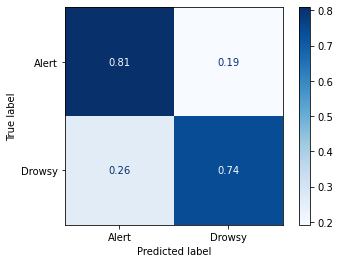

In [0]:
plot_confusion_matrix(clf_RF_hyp,X_test,y_test,normalize='true',cmap='Blues',labels=[0,1],display_labels=['Alert','Drowsy'])

In [0]:
#Accuracy
accuracy_score(y_test,clf_RF_hyp.predict(X_test))

0.7775653282345443

#Feature Extraction from Web Cam

In [0]:
def eye_aspect_ratio(eye):
  h=distance.euclidean(eye[0],eye[3])
  v1=distance.euclidean(eye[1],eye[5])
  v2=distance.euclidean(eye[2],eye[4])
  ans=(v1+v2)/(2.0 * h)
  return ans

In [0]:
def mouth_aspect_ratio(mouth):
  h=distance.euclidean(mouth[12],mouth[18])
  v=distance.euclidean(mouth[15],mouth[21])
  ans=v/(h*1.0)
  return ans

In [0]:
def circularity(eye):
    A = distance.euclidean(eye[1], eye[4])
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance.euclidean(eye[0], eye[1])
    p += distance.euclidean(eye[1], eye[2])
    p += distance.euclidean(eye[2], eye[3])
    p += distance.euclidean(eye[3], eye[4])
    p += distance.euclidean(eye[4], eye[5])
    p += distance.euclidean(eye[5], eye[0])
    return 4 * math.pi * Area /(p**2)

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      //await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return Image.open(f)

<IPython.core.display.Javascript object>

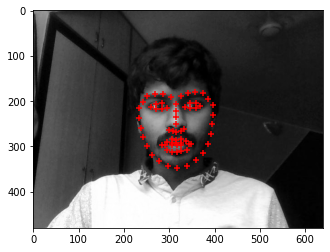

In [0]:
I = take_photo()
I.save("Image.jpg")
I=cv2.imread("Image.jpg")
I_gr=rgb2gray(I)
plt.imshow(I_gr,cmap='gray')
I = np.array(I)
frame_landmarks=extract_face_landmarks(I)
for x,y in frame_landmarks:
  plt.scatter(x,y,marker='+',c='r')

<IPython.core.display.Javascript object>

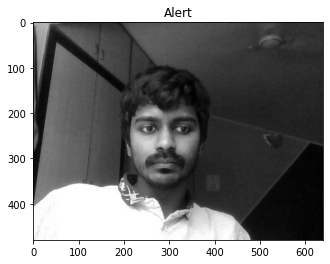

<IPython.core.display.Javascript object>

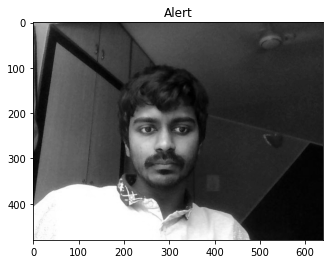

<IPython.core.display.Javascript object>

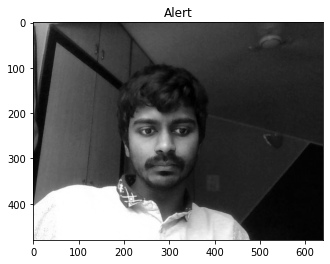

<IPython.core.display.Javascript object>

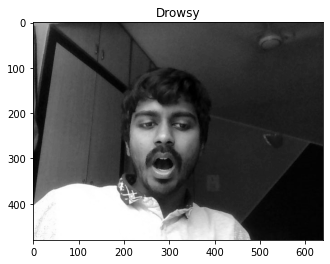

<IPython.core.display.Javascript object>

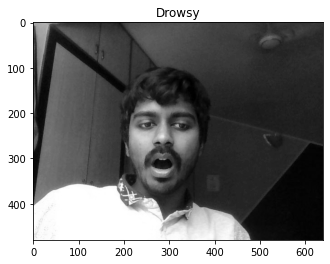

<IPython.core.display.Javascript object>

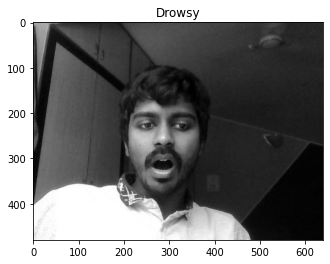

<IPython.core.display.Javascript object>

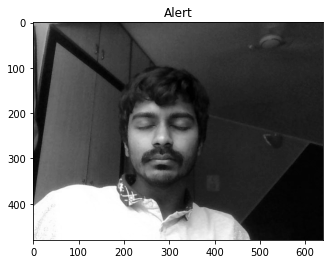

<IPython.core.display.Javascript object>

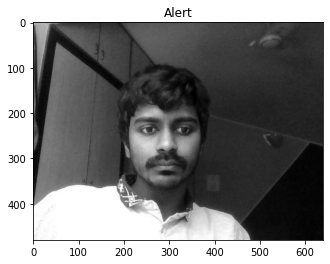

<IPython.core.display.Javascript object>

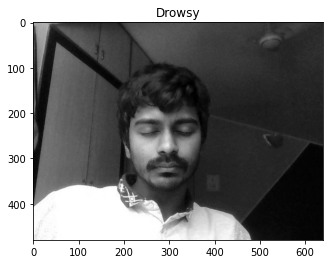

<IPython.core.display.Javascript object>

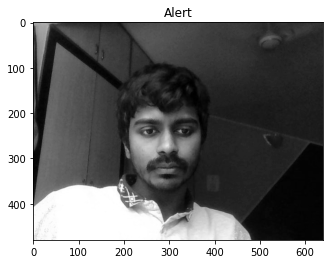

In [0]:
from IPython.display import clear_output
import PIL;
import time;
from tensorflow.keras.preprocessing.image import img_to_array

ctr=0
while(ctr<10):
  ctr+=1
  try:
    I = take_photo()
    I.save("Image.jpg")
    I=cv2.imread("Image.jpg")
    I_gr=rgb2gray(I)
    plt.imshow(I_gr,cmap="gray")
    
    I = np.array(I)
    frame_landmarks=extract_face_landmarks(I)

    #Features
    if(sum(sum(frame_landmarks))!=0):
        frame_landmarks=frame_landmarks[36:68]
        ear=eye_aspect_ratio(frame_landmarks)
        mar=mouth_aspect_ratio(frame_landmarks)
        circ=circularity(frame_landmarks)
        moe=mar/ear
    
        # predict the probability across output class
        label = clf_RF_hyp.predict([[ear,mar,circ,moe]])[0];
        if label==0:
          plt.title("Alert")
          plt.show()
        else:
          plt.title("Drowsy")
          plt.show()
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))